### Cel

### Trajectory Prediction

##### Agenda:
###### Ładowanie danych i importy
###### Ogólne zapoznanie się z danymi

#### - describe
#### - head
#### - info

#### Badania Eksploracyjne (EDA)

#### - countplot 
#### - histograms
#### - heatmap of correlation
#### - pairplot(sometimes time-consuming)
#### - scatterplots
#### - boxplots

#### Obróbka danych (Data PreProcessing)
#### - remove or fill any missing data
#### - remove unnecessary or repetitive features
#### - convert categorical string features to dummy variables

#### Modelowanie (Modeling)
#### - train test split
#### - normalizing Data MinMaxScaler
#### - creating Model
#### - evaluating model 

In [1]:
!pip install eli5 matplotlib pandas xgboost statsmodels seaborn tqdm hyperopt folium similaritymeasures --quiet

In [2]:
# Podstawowe biblioteki
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Przygotowanie danych
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Modele
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Poprawa Modelu 
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Wizualizacja
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sns.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pandas.plotting import scatter_matrix

# Utilities
import os
import re
import sys
import string
import time
import similaritymeasures
from datetime import datetime
from time import time
from scipy.stats import pointbiserialr
from scipy import sparse
from tqdm import tqdm
import eli5
from eli5.sklearn import PermutationImportance
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval

In [130]:
trajectory_path = '/Users/filipzarnecki/AiGames/data/trajectory_new/trajectory_challenge/'

In [131]:
train_df = pd.read_csv(trajectory_path + 'train_flights.csv')
test_df = pd.read_csv(trajectory_path + 'test_flights.csv')

In [132]:
def feature_engineering(df):
    # Date features
    df['airline_code'] = pd.factorize(df['airline_code'])[0]
    df['aircraft_model'] = pd.factorize(df['aircraft_model'])[0]
    df['origin_airport_id'] = pd.factorize(df['origin_airport_id'])[0]
    df['destination_airport_id'] = pd.factorize(df['destination_airport_id'])[0]
    df["start_position_datetime"] = pd.to_datetime(df["start_position_timestamp"])
    df["month"] =  df["start_position_datetime"].dt.month
    df["dayofweek"] =  df["start_position_datetime"].dt.dayofweek
    return df#df.drop(["start_position_timestamp","start_position_datetime"],axis = 1)

In [133]:
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)


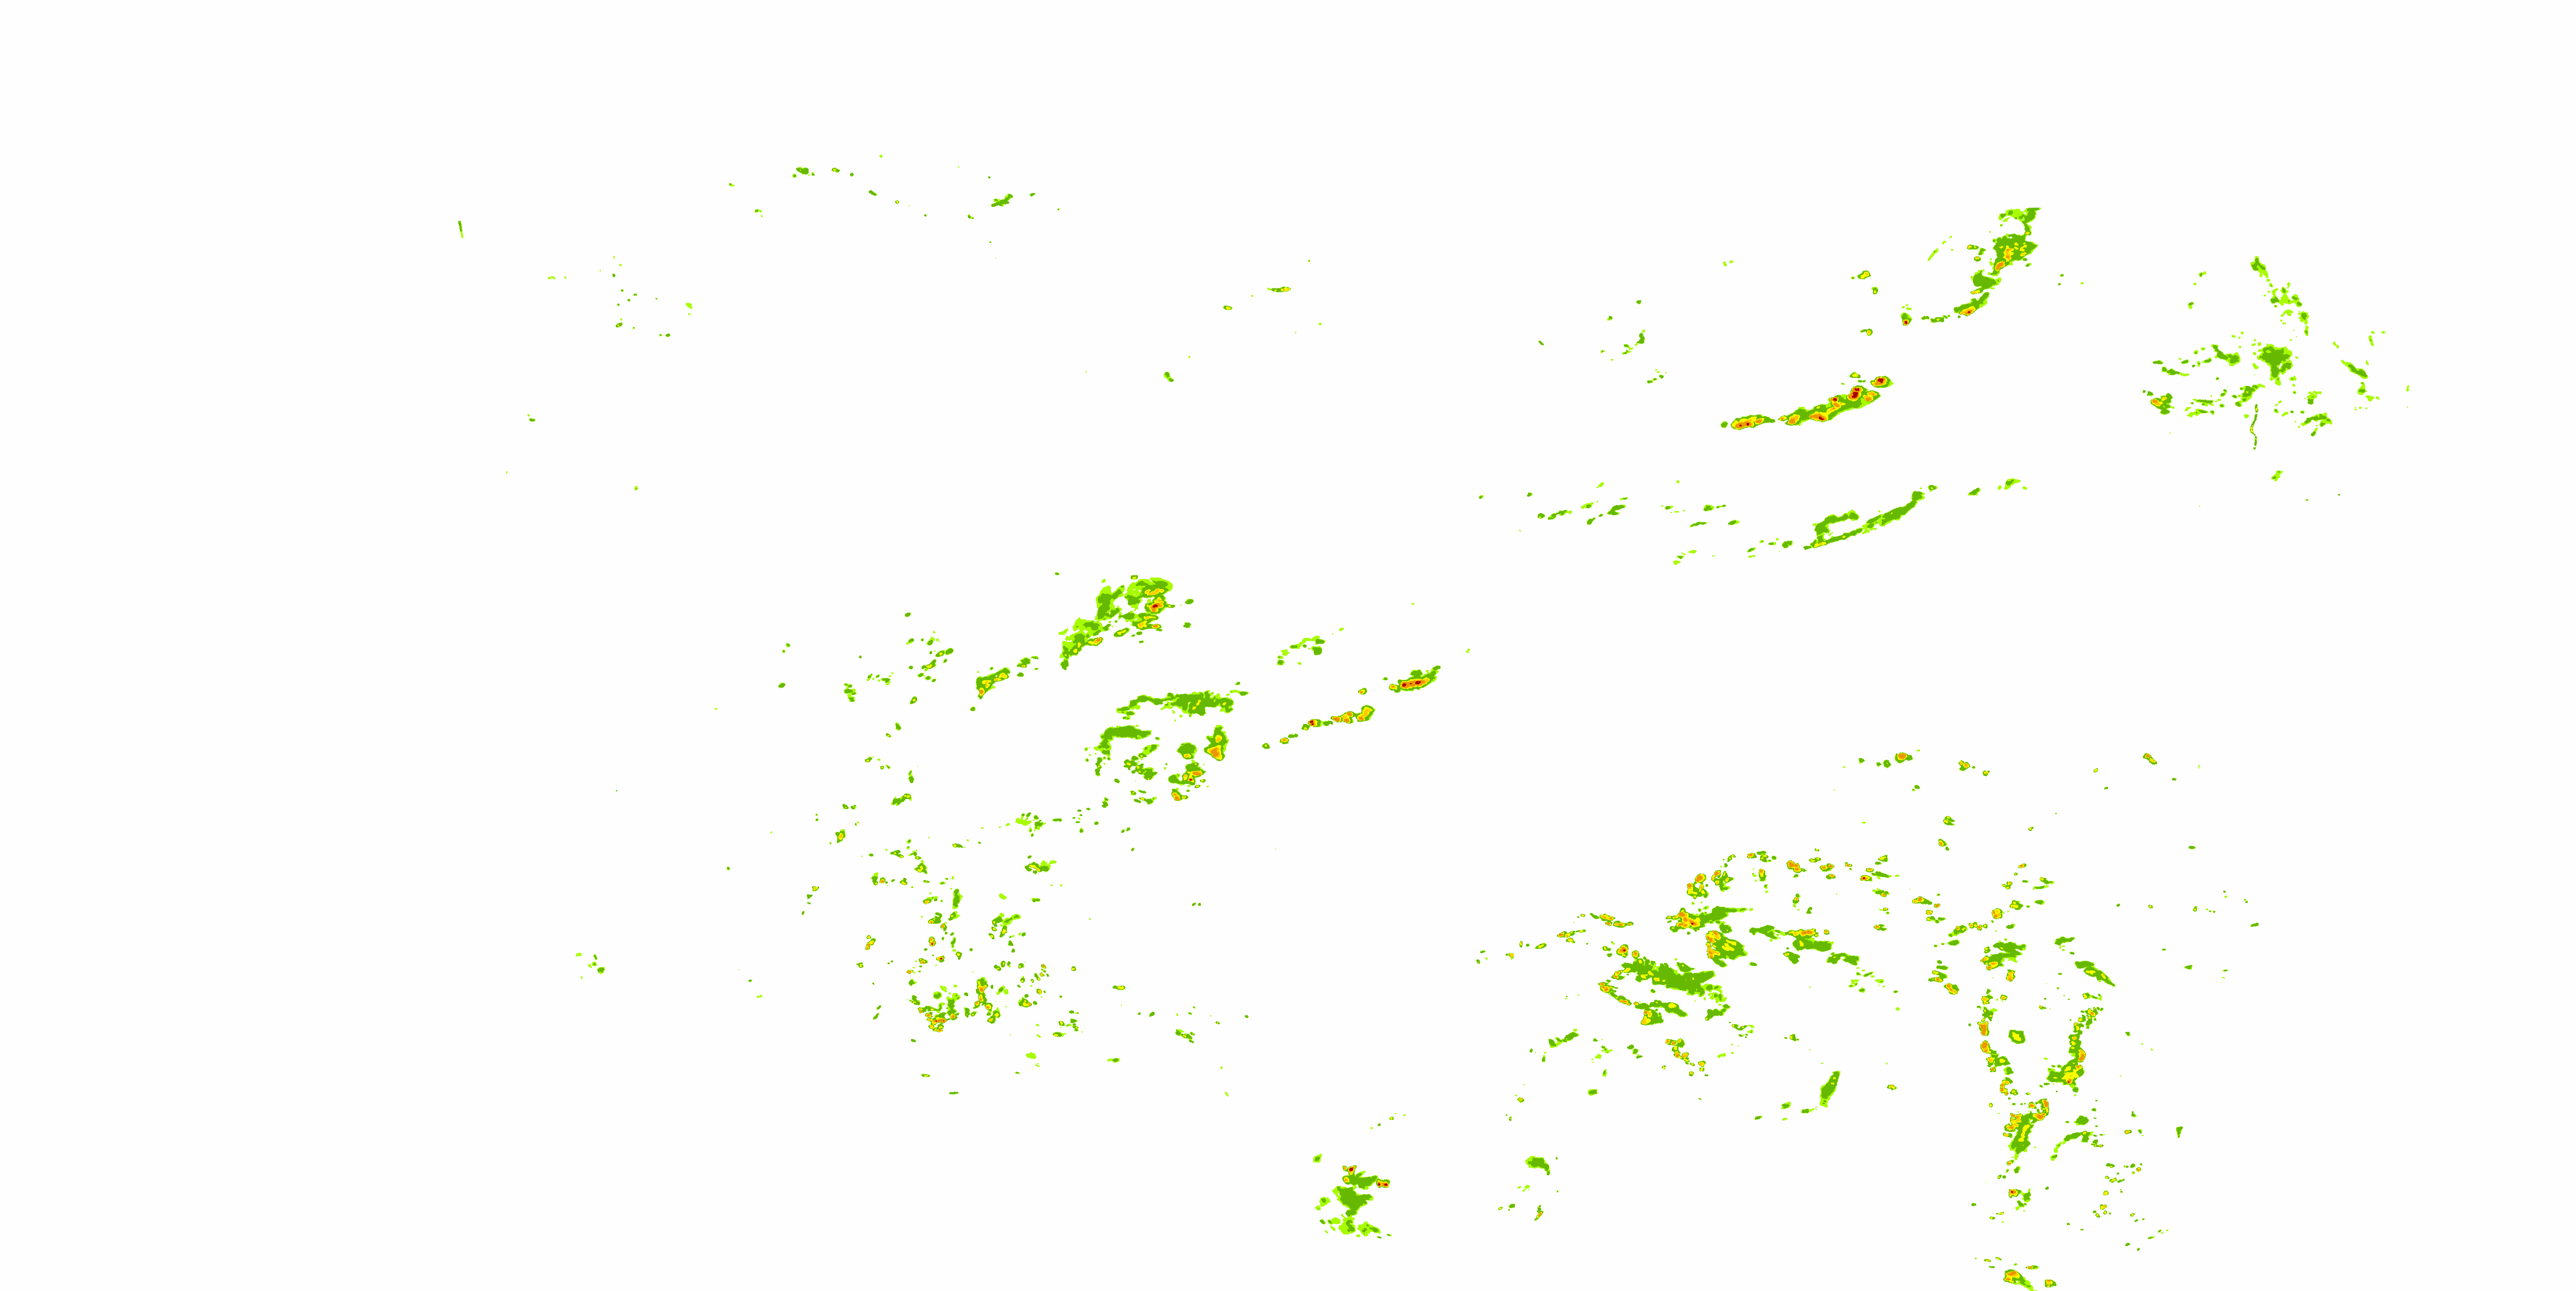

In [134]:
import folium
import numpy as np
from scipy import sparse

BOUNDARIES = [(21.9430, -67.5), (55.7765, -135)]
VIL_THRESHOLD_COLORS = [
    (10000, (0.63, 0.0, 0.01, 1.0)),
    (32.32, (0.87, 0.56, 0.0, 1.0)),
    (12.16, (0.95, 0.75, 0.0, 1.0)),
    (7.08, (0.93, 0.95, 0.0, 1.0)),
    (3.53, (0.38, 0.69, 0.0, 1.0)),
    (0.77, (0.63, 0.94, 0.0, 1.0)),
    (0.52, (0.9, 0.9, 0.9, 0.03)),
]


def _matrix_to_weather_colormap(sparse_matrix: sparse.csr_matrix) -> np.ndarray:
    matrix = sparse_matrix.toarray()
    result = np.zeros(shape=matrix.shape + (4,))
    for thresh, color in VIL_THRESHOLD_COLORS:
        result[matrix <= thresh] = color
    return result


def _plot_matrix(sparse_matrix: sparse.csr_matrix) -> folium.Map:
    fmap = folium.Map(location=[35, -100], zoom_start=6)

    colored_matrix = _matrix_to_weather_colormap(sparse_matrix=sparse_matrix)

    folium.raster_layers.ImageOverlay(
        colored_matrix,
        pixelated=True,
        opacity=0.8,
        mercator_project=True,
        bounds=BOUNDARIES,
    ).add_to(fmap)
    return fmap



def load_and_show_vil(file_path: str) -> folium.Map:
    sparse_matrix = sparse.load_npz(file_path)
    plot = _plot_matrix(sparse_matrix=sparse_matrix)
    return plot


load_and_show_vil(trajectory_path + '/VIL_merc/VIL-2022-07-01-00_00Z.npz')

In [135]:
# np_file_data = np.load('/home/goldas/Desktop/file-decryptor/trajectory_challenge/VIL_merc/VIL-2022-07-17-23_00Z.npz')
# lst = np_file_data.files
# for item in lst:
#     print(item)
#     print(np_file_data[item])

def get_weather_path(timestamp):
    date = timestamp.split('+')[0]
    #print(date.split()[1].split(':'))
    hour, minute, _ = date.split()[1].split(':')
    if int(minute) > 30:
        minute = '30'
    else:
        minute = '00'
    
    weather_timestamp = date.split()[0]+'-'+hour+'_'+minute+'Z'
    #print('VIL_merc/'+'VIL-'+weather_timestamp+'.npz')
    return trajectory_path +'VIL_merc/'+'VIL-'+weather_timestamp+'.npz'


In [136]:
get_weather_path(train_df['start_position_timestamp'][0])

'/Users/filipzarnecki/AiGames/data/trajectory_new/trajectory_challenge/VIL_merc/VIL-2022-07-06-00_00Z.npz'

In [137]:
BOUNDARIES = [(21.9430, -67.5), (55.7765, -135)]
def get_weather(weather_filepath, lat, lon):
    
    sparse_matrix = sparse.load_npz(weather_filepath)
    matrix = sparse_matrix.toarray()
    y, x = matrix.shape
    #print(y,x)
    
    # zakladajac ze 0 to 21 a 2500 to 55 to ile to 33
    # dlugosc = 55-21 = 34 -> 2500
    # moja dlugosc = 55-33 = 22 -> x
    
    index_y = int(y * (abs(BOUNDARIES[1][0]-lat))/(abs(BOUNDARIES[1][0]-BOUNDARIES[0][0])))
    #print(index_y,lat)
    index_x = int(x * (abs(BOUNDARIES[1][1]-lon))/(abs(BOUNDARIES[1][1]-BOUNDARIES[0][1])))
    #print(index_x,lon)
    
    weather_degrees = (175, 100, 50)
    weather_sums = []
    
    for weather in weather_degrees:
        weather_sum = 0
        for i in range(0,weather):
            for j in range(0,weather):
                
                if (0 <= index_y-int(weather/2)+i < y) and (0 <= index_x-int(weather/2)+j < x):
                    weather_sum += matrix[index_y-int(weather/2)+i][index_x-int(weather/2)+j]
                else:
                    continue
                    
        weather_sums.append(weather_sum)
        
    return weather_sums

get_weather(trajectory_path + 'VIL_merc/VIL-2022-07-06-01_00Z.npz', 32, -85)

[20974.90035706718, 2858.400219733259, 0.0]

In [149]:
routes_dir = trajectory_path + "routes/"
trajectories_dir = trajectory_path + "train_trajectories/"

def add_data(df, routes_dir_path, trajectories_dir_path, labels=True):
    route_array = []
    for i, row in tqdm(enumerate(df.iterrows())):
        single_trajectory_df = None
        if labels:
            try:
                single_trajectory_df = pd.read_csv(os.path.join(trajectories_dir_path, row[1]['id'] + ".csv"))
            except:
                print("Omitting..")
                continue
        #print(i)
        single_route_df = pd.read_csv(os.path.join(routes_dir_path,row[1]['id'] + ".csv"))
        single_route_df = single_route_df.drop(['seq_number'], axis = 1)
        single_route_df['type'] = pd.factorize(single_route_df['type'])[0]
        single_route_df['code'] = pd.factorize(single_route_df['code'])[0]
        timestamp = row[1]["start_position_timestamp"]
        weather_path = get_weather_path(timestamp)
        routes_with_weather = []
        for route_row in single_route_df.iterrows():
            #print(route_row[1])
            weather_data = get_weather(weather_path,route_row[1]['lat'],route_row[1]['lon'])
            #dummy_weather = [0,1,2]
            route_row = list(route_row[1])
            route_row = list(np.append(route_row,weather_data))
            
            #print(route_row)
            #print("route_row", route_row)
            routes_with_weather.append(route_row)
            
        #print(single_trajectory_df['lat'])
        #routes_with_weather.append()

            
        route_array.append(list(routes_with_weather))
#         print(route_array)
    #print(route_array)
    df['route_data'] = route_array 
    return df 

def get_labels(df, trajectories_dir_path):
    trajectories = []
    for i, row in enumerate(df.iterrows()):
        single_trajectory_df = None
        try:
            single_trajectory_df = pd.read_csv(os.path.join(trajectories_dir_path, row[1]['id'] + ".csv"))
        except:
            print("Omitting..")
            continue
        #print(single_trajectory_df)
        lat = list(single_trajectory_df['lat'])
        lon = list(single_trajectory_df['lon'])
        trajectories.append([lat, lon])
    return trajectories

train_df_ = add_data(train_df[:50000].copy(),routes_dir, trajectories_dir)
train_labels = get_labels(train_df[:50000].copy(), trajectories_dir)
#test_df_ = add_data(test_df[:100].copy(),routes_dir, trajectories_dir, labels=False)

2451it [1:25:53,  2.10s/it] 


KeyboardInterrupt: 

In [140]:
print(train_df_.shape)
print(len(train_labels))
print(len(train_labels[1][0]))

(50000, 12)
50000
1804


In [59]:
train_df_

,id,airline_code,aircraft_model,origin_airport_id,destination_airport_id,start_position_lat,start_position_lon,start_position_timestamp,start_position_datetime,month,dayofweek,route_data
0,flp_Wc7GvkHkegnYf9HTxA2Fhf,0,0,0,0,32.29568,-85.69633,2022-07-06 00:27:46+00:00,2022-07-06 00:27:46+00:00,7,2,"[[30.48322, -86.52604, 0.0, 0.0, 441.077913754..."
1,flp_HbeFfXcsxgPuTbuehGHmnt,0,0,1,0,31.64039,-86.36484,2022-07-06 00:28:57+00:00,2022-07-06 00:28:57+00:00,7,2,"[[30.47342, -87.18661, 0.0, 0.0, 0.92532120731..."
2,flp_3yfRRt3JKHFXphSvkb3pko,1,1,2,1,38.89379,-107.67822,2022-07-06 00:30:38+00:00,2022-07-06 00:30:38+00:00,7,2,"[[38.75763, -109.75346, 0.0, 0.0, 1538.0132450..."
3,flp_QARGqSan8SmDmbMCVRmkYu,1,1,3,1,40.35939,-107.96040,2022-07-06 00:34:35+00:00,2022-07-06 00:34:35+00:00,7,2,"[[40.43608, -109.51142, 0.0, 0.0, 768.43653675..."
4,flp_25Eao3xNAZ9TgPgCThpffB,2,2,4,2,29.46124,-92.51786,2022-07-06 00:38:57+00:00,2022-07-06 00:38:57+00:00,7,2,"[[29.99328, -90.25903, 0.0, 0.0, 7472.97952208..."
5,flp_iNL8ZS9tYX2NyuiakqX8GJ,1,1,5,1,38.46853,-101.99408,2022-07-06 00:39:04+00:00,2022-07-06 00:39:04+00:00,7,2,"[[37.76311, -99.96542, 0.0, 0.0, 21.5997802667..."
6,flp_7gJB5xoyoQryEDdmsuUjdo,0,3,6,0,31.49901,-82.68420,2022-07-06 00:46:57+00:00,2022-07-06 00:46:57+00:00,7,2,"[[29.69006, -82.27178, 0.0, 0.0, 1832.74147770..."
7,flp_edmQNKwQen2b8inz7QtzBs,0,3,7,0,31.50721,-85.40848,2022-07-06 00:49:33+00:00,2022-07-06 00:49:33+00:00,7,2,"[[30.35824, -85.7956, 0.0, 0.0, 1017.001251258..."
8,flp_YAX3zLgMhEcRBDGCWDCkyA,0,3,8,0,32.11180,-86.80606,2022-07-06 00:52:42+00:00,2022-07-06 00:52:42+00:00,7,2,"[[30.40727, -89.0701, 0.0, 0.0, 2716.996978667..."
9,flp_3QVmyFqmCHPNAZPZXxE5ec,0,4,9,1,40.58820,-107.81127,2022-07-06 00:53:26+00:00,2022-07-06 00:53:26+00:00,7,2,"[[40.78839, -111.97777, 0.0, 0.0, 13.120517593..."


In [148]:
BOUNDARIES = [(21.9430, -67.5), (55.7765, -135)]
def get_weather(weather_filepath, lat, lon):
    
    sparse_matrix = sparse.load_npz(weather_filepath)
    matrix = sparse_matrix.toarray()
    y, x = matrix.shape
    #print(y,x)
    
    # zakladajac ze 0 to 21 a 2500 to 55 to ile to 33
    # dlugosc = 55-21 = 34 -> 2500
    # moja dlugosc = 55-33 = 22 -> x
    
    index_y = int(y * (abs(BOUNDARIES[1][0]-lat))/(abs(BOUNDARIES[1][0]-BOUNDARIES[0][0])))
    #print(index_y,lat)
    index_x = int(x * (abs(BOUNDARIES[1][1]-lon))/(abs(BOUNDARIES[1][1]-BOUNDARIES[0][1])))
    #print(index_x,lon)
    
    weather_degrees = [50]
    weather_sums = []
    
    for weather in weather_degrees:
        weather_sum = 0
        matrix_slice = matrix[index_y-int(weather/2):index_y+int(weather/2),index_x-int(weather/2):index_x+int(weather/2)]
        #matrix_slice = matrix[10:60,10:60]
        #print(matrix_slice.shape)
        weather_sum = np.sum(matrix_slice)
        #for i in range(0,weather):
        #    for j in range(0,weather):
        #        
        #        if (0 <= index_y-int(weather/2)+i < y) and (0 <= index_x-int(weather/2)+j < x):
        #            weather_sum += matrix[index_y-int(weather/2)+i][index_x-int(weather/2)+j]
        #        else:
        #            continue
                    
        weather_sums.append(weather_sum)
        
    return weather_sums

get_weather(trajectory_path + 'VIL_merc/VIL-2022-07-06-01_00Z.npz', 32, -85)

[0.0]

In [141]:
out_data = pd.DataFrame({"sample": train_df_["route_data"], "labels": train_labels})

In [142]:
out = []
for _,row in out_data.iterrows():
    out.append({
        "sample": row["sample"],
        "labels": row["labels"]
    })

In [144]:
with open("/Users/filipzarnecki/AiGames/data/prepared_data/data.json", "w") as f:
    json.dump(out, f)

In [64]:
train_df_["route_data"][0]

[[30.48322, -86.52604, 0.0, 0.0, 441.07791375468577, 104.86648152104245, 0.0],
 [30.52402, -86.40536, 1.0, 1.0, 573.3451338236562, 216.78884243293538, 0.0],
 [31.88624, -85.93825, 1.0, 2.0, 2688.0654316842893, 0.0, 0.0],
 [33.02376,
  -85.22206,
  2.0,
  3.0,
  6242.104556413775,
  1931.582384716316,
  381.22989593188055],
 [33.17929,
  -85.02036,
  2.0,
  4.0,
  14799.411603138231,
  1949.1439558091836,
  1868.7801751762315],
 [33.31942,
  -84.83804,
  2.0,
  5.0,
  16377.601855526294,
  2014.1190832239597,
  1647.0009460737865],
 [33.73295,
  -84.58158,
  2.0,
  6.0,
  9786.099429304622,
  6629.765312662516,
  482.8638569292257],
 [33.73295,
  -84.4346,
  3.0,
  7.0,
  9616.9658497886,
  7180.221564379177,
  395.4637287514855],
 [33.73294,
  -84.30531,
  2.0,
  8.0,
  8915.164647359301,
  7442.84188360278,
  358.734092226934],
 [33.73331,
  -84.1388,
  2.0,
  9.0,
  8716.061891537916,
  6491.960814234162,
  277.7599414044614],
 [33.73318,
  -84.03888,
  2.0,
  10.0,
  8707.7755058450

In [ ]:
trajectory = pd.read_csv("/home/goldas/Desktop/file-decryptor/trajectory_challenge/train_trajectories/flp_22F3kQCKpZAWmXaPQcigSY.csv")
trajectory

In [ ]:
route = pd.read_csv('/home/goldas/Desktop/file-decryptor/trajectory_challenge/routes/flp_22F3kQCKpZAWmXaPQcigSY.csv')
route

In [ ]:
lst = []
for value in route['lat']:
    lst.append(value)
    #lst.append(np.nan)
    print(lst)
    
from scipy.interpolate import interp1d

In [ ]:
from scipy.interpolate import UnivariateSpline
import numpy as np

xs = np.arange(10)
print(xs)
ys = xs**2 + np.sin(xs) + 1
print(ys)
interp_func = UnivariateSpline(xs, ys)

newarr = interp_func(np.arange(2.1, 3, 0.1))

print(newarr)

In [ ]:
y_f = interp1d(x_lst, lst, 'linear')
y_f(3.5)

In [ ]:
x_lst = []
for i in range(len(lst)):
    x_lst.append(i)

In [ ]:
similaritymeasures.frechet_dist(route[["lat","lon"]].values, trajectory[["lat","lon"]].values)